In [1]:
# Change value of k in next cell to generate adversarial samples for k
import os

import numpy as np

import matplotlib
matplotlib.use('Agg')           # noqa: E402
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import tensorflow as tf
tf.compat.v1.disable_eager_execution()
__all__ = [
    'fgm',                      # fast gradient method
    'fgmt'                      # fast gradient method with target
]

def fgmt(model, x, y=None, eps=0.01, epochs=1, sign=True, clip_min=0.,
         clip_max=1.):
    
    xadv = tf.compat.v1.identity(x)

    ybar = model(xadv)
    ydim = ybar.get_shape().as_list()[1]
    n = tf.compat.v1.shape(ybar)[0]

    if y is None:
        indices = tf.compat.v1.argmin(ybar, axis=1)
    else:
        indices = tf.compat.v1.cond(tf.compat.v1.equal(0, tf.compat.v1.rank(y)),
                          lambda: tf.compat.v1.zeros([n], dtype=tf.compat.v1.int32) + y,
                          lambda: tf.compat.v1.zeros([n], dtype=tf.compat.v1.int32))

    target = tf.compat.v1.cond(
        tf.compat.v1.equal(ydim, 1),
        lambda: 1 - ybar,
        lambda: tf.compat.v1.one_hot(indices, ydim, on_value=1.0, off_value=0.0))

    if 1 == ydim:
        loss_fn = tf.compat.v1.nn.sigmoid_cross_entropy_with_logits
    else:
        loss_fn = tf.compat.v1.nn.softmax_cross_entropy_with_logits

    if sign:
        noise_fn = tf.compat.v1.sign
    else:
        noise_fn = tf.compat.v1.identity

    eps = -tf.compat.v1.abs(eps)

    def _cond(xadv, i):
        return tf.compat.v1.less(i, epochs)

    def _body(xadv, i):
        ybar, logits = model(xadv, logits=True)
        loss = loss_fn(labels=target, logits=logits)
        dy_dx, = tf.compat.v1.gradients(loss, xadv)
        xadv = tf.compat.v1.stop_gradient(xadv + eps*noise_fn(dy_dx))
        xadv = tf.compat.v1.clip_by_value(xadv, clip_min, clip_max)
        return xadv, i+1

    xadv, _ = tf.compat.v1.while_loop(_cond, _body, (xadv, 0), back_prop=False,
                            name='fast_gradient_target')
    return xadv


img_size = 28
img_chan = 1
n_classes = 10


print('\nLoading MNIST')

mnist = tf.compat.v1.keras.datasets.mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = np.reshape(X_train, [-1, img_size, img_size, img_chan])
X_train = X_train.astype(np.float32) / 255
X_test = np.reshape(X_test, [-1, img_size, img_size, img_chan])
X_test = X_test.astype(np.float32) / 255

to_categorical = tf.compat.v1.keras.utils.to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print('\nSpliting data')

ind = np.random.permutation(X_train.shape[0])
X_train, y_train = X_train[ind], y_train[ind]

VALIDATION_SPLIT = 0.1
n = int(X_train.shape[0] * (1-VALIDATION_SPLIT))
X_valid = X_train[n:]
X_train = X_train[:n]
y_valid = y_train[n:]
y_train = y_train[:n]

print('\nConstruction graph')


def model(x, logits=False, training=False):
    with tf.compat.v1.variable_scope('conv0'):
        z = tf.compat.v1.layers.conv2d(x, filters=32, kernel_size=[3, 3],
                             padding='same', activation=tf.compat.v1.nn.relu)
        z = tf.compat.v1.layers.max_pooling2d(z, pool_size=[2, 2], strides=2)

    with tf.compat.v1.variable_scope('conv1'):
        z = tf.compat.v1.layers.conv2d(z, filters=64, kernel_size=[3, 3],
                             padding='same', activation=tf.compat.v1.nn.relu)
        z = tf.compat.v1.layers.max_pooling2d(z, pool_size=[2, 2], strides=2)

    with tf.compat.v1.variable_scope('flatten'):
        shape = z.get_shape().as_list()
        z = tf.compat.v1.reshape(z, [-1, np.prod(shape[1:])])

    with tf.compat.v1.variable_scope('mlp'):
        z = tf.compat.v1.layers.dense(z, units=128, activation=tf.compat.v1.nn.relu)
        z = tf.compat.v1.layers.dropout(z, rate=0.25, training=training)

    logits_ = tf.compat.v1.layers.dense(z, units=10, name='logits')
    y = tf.compat.v1.nn.softmax(logits_, name='ybar')

    if logits:
        return y, logits_
    return y


class Dummy:
    pass


env = Dummy()


with tf.compat.v1.variable_scope('model'):
    env.x = tf.compat.v1.placeholder(tf.compat.v1.float32, (None, img_size, img_size, img_chan),
                           name='x')
    env.y = tf.compat.v1.placeholder(tf.compat.v1.float32, (None, n_classes), name='y')
    env.training = tf.compat.v1.placeholder_with_default(False, (), name='mode')

    env.ybar, logits = model(env.x, logits=True, training=env.training)

    with tf.compat.v1.variable_scope('acc'):
        count = tf.compat.v1.equal(tf.compat.v1.argmax(env.y, axis=1), tf.compat.v1.argmax(env.ybar, axis=1))
        env.acc = tf.compat.v1.reduce_mean(tf.compat.v1.cast(count, tf.compat.v1.float32), name='acc')

    with tf.compat.v1.variable_scope('loss'):
        xent = tf.compat.v1.nn.softmax_cross_entropy_with_logits(labels=env.y,
                                                       logits=logits)
        env.loss = tf.compat.v1.reduce_mean(xent, name='loss')

    with tf.compat.v1.variable_scope('train_op'):
        optimizer = tf.compat.v1.train.AdamOptimizer()
        env.train_op = optimizer.minimize(env.loss)

    env.saver = tf.compat.v1.train.Saver()

with tf.compat.v1.variable_scope('model', reuse=True):
    env.adv_eps = tf.compat.v1.placeholder(tf.compat.v1.float32, (), name='adv_eps')
    env.adv_epochs = tf.compat.v1.placeholder(tf.compat.v1.int32, (), name='adv_epochs')
    env.adv_y = tf.compat.v1.placeholder(tf.compat.v1.int32, (), name='adv_y')
    env.x_fgmt = fgmt(model, env.x, y=env.adv_y, epochs=env.adv_epochs,
                      eps=env.adv_eps)

print('\nInitializing graph')

sess = tf.compat.v1.InteractiveSession()
sess.run(tf.compat.v1.global_variables_initializer())
sess.run(tf.compat.v1.local_variables_initializer())


def evaluate(sess, env, X_data, y_data, batch_size=128):
    """
    Evaluate TF.compat.v1 model by running env.loss and env.acc.
    """
    print('\nEvaluating')

    n_sample = X_data.shape[0]
    n_batch = int((n_sample+batch_size-1) / batch_size)
    loss, acc = 0, 0

    for batch in range(n_batch):
        print(' batch {0}/{1}'.format(batch + 1, n_batch), end='\r')
        start = batch * batch_size
        end = min(n_sample, start + batch_size)
        cnt = end - start
        batch_loss, batch_acc = sess.run(
            [env.loss, env.acc],
            feed_dict={env.x: X_data[start:end],
                       env.y: y_data[start:end]})
        loss += batch_loss * cnt
        acc += batch_acc * cnt
    loss /= n_sample
    acc /= n_sample

    print(' loss: {0:.4f} acc: {1:.4f}'.format(loss, acc))
    return loss, acc


def train(sess, env, X_data, y_data, X_valid=None, y_valid=None, epochs=1,
          load=False, shuffle=True, batch_size=128, name='model'):
    """
    Train a TF.compat.v1 model by running env.train_op.
    """
    if load:
        if not hasattr(env, 'saver'):
            return print('\nError: cannot find saver op')
        print('\nLoading saved model')
        return env.saver.restore(sess,tf.compat.v1.train.latest_checkpoint('./'))
        #return env.saver.restore(sess, './'.format(name))

    print('\nTrain model')
    n_sample = X_data.shape[0]
    n_batch = int((n_sample+batch_size-1) / batch_size)
    for epoch in range(epochs):
        print('\nEpoch {0}/{1}'.format(epoch + 1, epochs))

        if shuffle:
            print('\nShuffling data')
            ind = np.arange(n_sample)
            np.random.shuffle(ind)
            X_data = X_data[ind]
            y_data = y_data[ind]

        for batch in range(n_batch):
            print(' batch {0}/{1}'.format(batch + 1, n_batch), end='\r')
            start = batch * batch_size
            end = min(n_sample, start + batch_size)
            sess.run(env.train_op, feed_dict={env.x: X_data[start:end],
                                              env.y: y_data[start:end],
                                              env.training: True})
        if X_valid is not None:
            evaluate(sess, env, X_valid, y_valid)

    if hasattr(env, 'saver'):
        print('\n Saving model')
        os.makedirs('model', exist_ok=True)
        env.saver.save(sess, 'model/{}'.format(name))




print('\nTraining')

train(sess, env, X_train, y_train, X_valid, y_valid, load=False, epochs=5,
      name='mnist')




Loading MNIST

Spliting data

Construction graph


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:120: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/convolutional.py:563: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:121: UserWarning: `tf.layers.max_pooling2d` is deprecated and will be removed in a future version. Please use `tf.keras.layers.MaxPooling2D` instead.
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/pooling.py:568: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:125: UserWarning: `tf.layers.conv2d` is deprecated and wil

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.


Initializing graph

Training

Train model

Epoch 1/5

Shuffling data
 batch 422/422
Evaluating
 loss: 0.0678 acc: 0.9783

Epoch 2/5

Shuffling data
 batch 422/422
Evaluating
 loss: 0.0435 acc: 0.9863

Epoch 3/5

Shuffling data
 batch 422/422
Evaluating
 loss: 0.0432 acc: 0.9868

Epoch 4/5

Shuffling data
 batch 422/422
Evaluating
 loss: 0.0356 acc: 0.9895

Epoch 5/5

Shuffling data

Evaluating
 loss: 0.0314 acc: 0.9900

 Saving model



Evaluating on clean data

Evaluating
 loss: 0.0265 acc: 0.9915

Generating adversarial data

Making adversarials via FGSM
 batch 79/79

Evaluating on adversarial data

Evaluating
 loss: 0.6951 acc: 0.7875

Randomly sample adversarial data from each category

Predicting
 batch 79/79

Predicting
 batch 79/79
Target 0
Target 1
Target 2
Target 3
Target 4
Target 5
Target 7
Target 8
Target 9

Plotting results

Saving figure


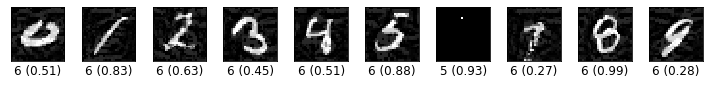

In [19]:
k = 6 #change k here
def predict(sess, env, X_data, batch_size=128):
    """
    Do inference by running env.ybar.
    """
    print('\nPredicting')
    n_classes = env.ybar.get_shape().as_list()[1]

    n_sample = X_data.shape[0]
    n_batch = int((n_sample+batch_size-1) / batch_size)
    yval = np.empty((n_sample, n_classes))

    for batch in range(n_batch):
        print(' batch {0}/{1}'.format(batch + 1, n_batch), end='\r')
        start = batch * batch_size
        end = min(n_sample, start + batch_size)
        y_batch = sess.run(env.ybar, feed_dict={env.x: X_data[start:end]})
        yval[start:end] = y_batch
    print()
    return yval


def make_fgmt(sess, env, X_data, epochs=1, eps=0.01, batch_size=128):
    """
    Generate FGSM by running env.x_fgsm.
    """
    print('\nMaking adversarials via FGSM')

    n_sample = X_data.shape[0]
    n_batch = int((n_sample + batch_size - 1) / batch_size)
    X_adv = np.empty_like(X_data)

    for batch in range(n_batch):
        print(' batch {0}/{1}'.format(batch + 1, n_batch), end='\r')
        start = batch * batch_size
        end = min(n_sample, start + batch_size)
        adv = sess.run(env.x_fgmt, feed_dict={
            env.x: X_data[start:end],
            #env.adv_y: np.random.choice(n_classes),
            env.adv_y: k, #uncomment
            env.adv_eps: eps,
            env.adv_epochs: epochs})
        X_adv[start:end] = adv
    print()

    return X_adv


print('\nEvaluating on clean data')

evaluate(sess, env, X_test, y_test)

print('\nGenerating adversarial data')

X_adv = make_fgmt(sess, env, X_test, eps=0.02, epochs=8)

print('\nEvaluating on adversarial data')

evaluate(sess, env, X_adv, y_test)

print('\nRandomly sample adversarial data from each category')

y1 = predict(sess, env, X_test)
y2 = predict(sess, env, X_adv)

z0 = np.argmax(y_test, axis=1)
z1 = np.argmax(y1, axis=1)
z2 = np.argmax(y2, axis=1)

X_tmp = np.empty((10, 28, 28))
y_tmp = np.empty((10, 10))
for i in range(10):
    if i==k:
        continue
    print('Target {0}'.format(i))
    ind, = np.where(np.all([z0 == i, z1 == i, z2 == k], axis=0)) #z2!=i
    cur = np.random.choice(ind)
    X_tmp[i] = np.squeeze(X_adv[cur])
    y_tmp[i] = y2[cur]

print('\nPlotting results')

fig = plt.figure(figsize=(10, 1.2))
gs = gridspec.GridSpec(1, 10, wspace=0.05, hspace=0.05)

label = np.argmax(y_tmp, axis=1)
proba = np.max(y_tmp, axis=1)
for i in range(10):
    ax = fig.add_subplot(gs[0, i])
    ax.imshow(X_tmp[i], cmap='gray', interpolation='none')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('{0} ({1:.2f})'.format(label[i], proba[i]),
                  fontsize=12)

print('\nSaving figure')

gs.tight_layout(fig)
os.makedirs('img', exist_ok=True)
plt.savefig('img/fgmt_mnist2.png')


In [20]:
z_tmp = np.argmax(y_tmp, axis=1)
print(z_tmp)

[6 6 6 6 6 6 5 6 6 6]
